# Inteligência Artificial Explicável

1. Class Activation Mapping
2. Gradient Weighted Class Activation Mapping
3. Local Interpretable Model-Agnostic Explanations

In [1]:
# Bibliotecas necessárias para todas as etapas

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [2]:
# Importando modelo ResNet101 pré-treinado do pacote TensorFlow

modelo_resnet = tf.keras.applications.ResNet101(
    weights='imagenet' # Pesos do modelo pré-treinado sobre o dataset ImageNet
)

(-0.5, 2582.5, 2582.5, -0.5)

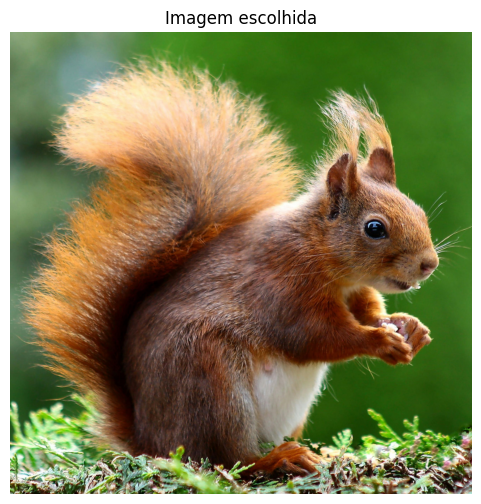

In [3]:
# Seleção da imagem para predição e explicação

imagem = PIL.Image.open('img/squirrel.jpg')

plt.figure(figsize=(6,6))
plt.imshow(imagem)
plt.title("Imagem escolhida")
plt.axis('off')

In [4]:
# Conversão da imagem para predição

imagem = imagem.resize((224,224)) # Entrada esperada do modelo é uma imagem do tamanho 224x224
imagem_array = np.array(imagem) # Converter matriz em array
imagem_array = np.expand_dims(imagem_array, axis=0) # Dimensão extra para o 'batch'
imagem_array = tf.keras.applications.resnet.preprocess_input(imagem_array) # Normalizar os pixels da imagem

In [5]:
# Fazer a predição do modelo

num_classes_preditas = 5 # Define quantas classes o modelo retornará como resposta

predicoes = modelo_resnet.predict(imagem_array) # Chama para o modelo
predicoes_decodificadas = tf.keras.applications.resnet.decode_predictions(predicoes, top=num_classes_preditas)[0] # Retora as top {num_classes_preditas} classes preditas 

for i, (imagenet_id, nome_classe, score_classe) in enumerate(predicoes_decodificadas):
    print(f"{i+1}: {nome_classe} ({score_classe:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1: fox_squirrel (0.98)
2: hare (0.01)
3: marmot (0.00)
4: guinea_pig (0.00)
5: wood_rabbit (0.00)


In [6]:
# Importando bibliotecas para as XAI's

from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from lime import lime_image
from skimage.segmentation import mark_boundaries

d:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Coletando informações da classe predita

classe_predita = np.argmax(predicoes[0]) # Retorna o ID da classe predita de acordo com a ResNet101
classe_score = CategoricalScore([classe_predita])

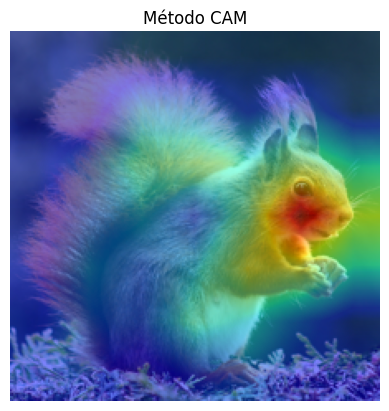

In [8]:
# Explicar a predição usando o método CAM

ultima_camada_convolucional = "conv5_block3_out" 
ultima_camada_convolucional_modelo = tf.keras.Model(inputs=modelo_resnet.input, outputs=modelo_resnet.get_layer(ultima_camada_convolucional).output)
saida_camada_convolucional = ultima_camada_convolucional_modelo(imagem_array)

final_dense_layer = modelo_resnet.get_layer("predictions")
pesos_ativacao = final_dense_layer.get_weights()[0]
pesos_ativacao_classe = pesos_ativacao[:, classe_predita]

cam = np.dot(saida_camada_convolucional[0], pesos_ativacao_classe)
heatmap_cam = tf.image.resize(cam[np.newaxis, :, :, np.newaxis], (224, 224)).numpy().squeeze()

plt.title("Método CAM")
plt.imshow(imagem)
plt.imshow(heatmap_cam, cmap='jet', alpha=0.5)  # Overlay do CAM sobre a imagem
plt.axis('off')
plt.show()

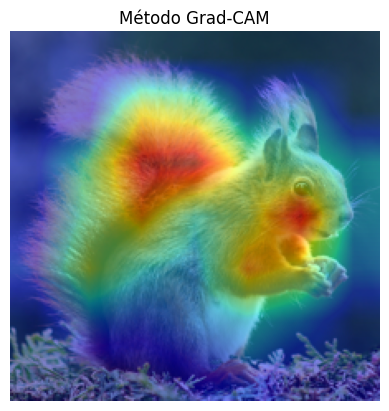

In [9]:
# Explicar a predição usando o método Grad-CAM

ultima_camada_convolucional = modelo_resnet.get_layer("conv5_block3_out")
ultima_camada_convolucional_modelo = tf.keras.Model(modelo_resnet.inputs, ultima_camada_convolucional.output)

input_classificador = tf.keras.Input(shape=ultima_camada_convolucional.output.shape[1:])
x = input_classificador
for layer_name in ["avg_pool", "predictions"]:
    x = modelo_resnet.get_layer(layer_name)(x)
modelo_classificador = tf.keras.Model(input_classificador, x)

# Cálculo dos gradientes
with tf.GradientTape() as tape:
    saida_camada_convolucional = ultima_camada_convolucional_modelo(imagem_array)
    tape.watch(saida_camada_convolucional)
    predicoes = modelo_classificador(saida_camada_convolucional)
    predicao_classe = predicoes[:, classe_predita]

gradientes = tape.gradient(predicao_classe, saida_camada_convolucional) # Gradientes vindo da última camada convolucional em respeito à classe predita
global_average_pooling = tf.reduce_mean(gradientes, axis=(0, 1, 2)) # Cálculo do Global Average Pooling sobre os gradientes

saida_camada_convolucional = saida_camada_convolucional.numpy()[0] # Multiplicação de cada mapa de atributos da camada convolucional por seu peso de importância
global_average_pooling = global_average_pooling.numpy()
for i in range(global_average_pooling.shape[-1]):
    saida_camada_convolucional[:, :, i] *= global_average_pooling[i] 

gradcam = np.mean(saida_camada_convolucional, axis=-1) # Cálculo da média dos mapas de atributos para gerar a imagem

gradcam = np.maximum(gradcam, 0) # Aplicando a função de ativação ReLU como mencionado no artigo
gradcam /= np.max(gradcam) 

gradcam_heatmap = tf.image.resize(gradcam[np.newaxis, :, :, np.newaxis], (224, 224)).numpy().squeeze() # Gerando o mapa de calor de acordo com os valores do Grad-CAM

plt.title("Método Grad-CAM")
plt.imshow(imagem)
plt.imshow(gradcam_heatmap, cmap='jet', alpha=0.5)  # Overlay do Grad-CAM sobre a imagem
plt.axis('off')
plt.show()

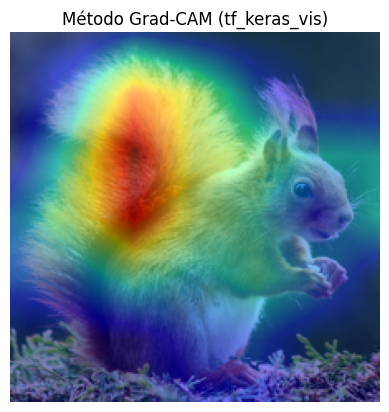

In [10]:
# Explicar a predição usando o método Grad-CAM (usando o pacote tf_keras_vis)

gradcam = Gradcam(modelo_resnet) # Chamada do método Grad-CAM sobre o modelo ResNet101

gradcam_heatmap = gradcam(classe_score, imagem_array, penultimate_layer=-1) # Responsável por gerar o mapa de ativação
gradcam_heatmap = np.uint8(255 * gradcam_heatmap[0])                        

plt.title("Método Grad-CAM (tf_keras_vis)")
plt.imshow(imagem)
plt.imshow(gradcam_heatmap, cmap='jet', alpha=0.5) # Overlay do mapa de calor sobre a imagem
plt.axis('off')
plt.show()


In [11]:
# Explicar a predição usando o método LIME (package lime)

modelo_explicavel = lime_image.LimeImageExplainer() # Modelo intermediário para gerar explicações
explicacao = modelo_explicavel.explain_instance(imagem_array[0],  # Gerar a explicação da imagem usando LIME
                                         modelo_resnet.predict, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)


  1%|          | 6/1000 [00:00<00:18, 55.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


  2%|▏         | 17/1000 [00:04<04:41,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step


  3%|▎         | 26/1000 [00:06<02:57,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  4%|▍         | 39/1000 [00:07<01:49,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


  5%|▍         | 48/1000 [00:08<01:48,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step


  6%|▌         | 57/1000 [00:09<01:42,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step


  7%|▋         | 66/1000 [00:10<01:36,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step


  8%|▊         | 75/1000 [00:11<01:33,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


  9%|▉         | 88/1000 [00:13<01:19, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step


 10%|▉         | 96/1000 [00:14<01:28, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step


 10%|█         | 105/1000 [00:15<01:28, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step


 12%|█▏        | 115/1000 [00:16<01:24, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 13%|█▎        | 128/1000 [00:17<01:14, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 14%|█▍        | 139/1000 [00:19<01:19, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 15%|█▍        | 148/1000 [00:20<01:34,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 16%|█▌        | 156/1000 [00:22<02:08,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 169/1000 [00:24<01:29,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 18%|█▊        | 178/1000 [00:25<01:38,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step


 19%|█▊        | 186/1000 [00:26<01:31,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


 20%|█▉        | 195/1000 [00:27<01:23,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step


 20%|██        | 205/1000 [00:28<01:23,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


 22%|██▏       | 215/1000 [00:29<01:17, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step


 22%|██▎       | 225/1000 [00:31<01:13, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step


 24%|██▎       | 235/1000 [00:32<01:11, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step


 24%|██▍       | 245/1000 [00:33<01:09, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▌       | 255/1000 [00:34<01:16,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step


 26%|██▋       | 265/1000 [00:35<01:10, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


 28%|██▊       | 275/1000 [00:36<01:07, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step


 28%|██▊       | 285/1000 [00:37<01:07, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step


 30%|██▉       | 298/1000 [00:39<00:58, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 306/1000 [00:40<01:18,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


 32%|███▏      | 319/1000 [00:41<00:57, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step


 33%|███▎      | 328/1000 [00:42<01:05, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


 34%|███▎      | 336/1000 [00:43<01:06,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


 35%|███▍      | 346/1000 [00:44<01:00, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 36%|███▌      | 356/1000 [00:45<00:56, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


 37%|███▋      | 366/1000 [00:46<00:54, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step


 38%|███▊      | 376/1000 [00:47<00:52, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


 39%|███▊      | 386/1000 [00:48<00:51, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


 40%|███▉      | 396/1000 [00:49<00:50, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 41%|████      | 406/1000 [00:50<00:49, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step


 42%|████▏     | 415/1000 [00:51<00:51, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 43%|████▎     | 426/1000 [00:52<00:47, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 44%|████▍     | 438/1000 [00:54<00:44, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step


 45%|████▍     | 447/1000 [00:55<00:52, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step


 46%|████▌     | 456/1000 [00:56<00:53, 10.16it/s]

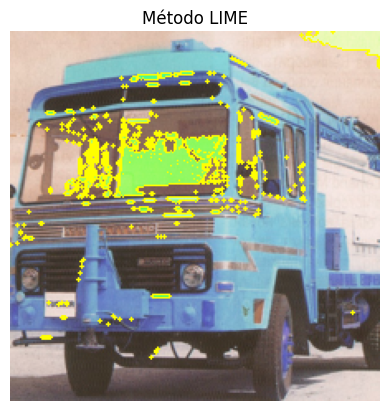

In [ ]:
# Plotar a explicação do método LIME 
temp, mask = explicacao.get_image_and_mask(explicacao.top_labels[0], # Visualizar a explicação para a classe prevista
                                            positive_only=False, 
                                            num_features=10, 
                                            hide_rest=False)

plt.title("Método LIME")
plt.imshow(mark_boundaries(temp / 255 + 0.5, mask)) # Exibir a imagem com as "máscaras" do LIME
plt.axis('off')
plt.show()